<a href="https://colab.research.google.com/github/ulissigroup/amptorch/blob/active_learning/amptorch/active_learning/examples/neb_al_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Installation of packages

In [1]:
!pip install -q git+https://github.com/ulissigroup/amptorch.git@active_learning
!pip install -q git+https://github.com/mshuaibii/SIMPLE-NN.git
!pip install -q amp-atomistics
!pip install -q --upgrade dftbook

     |████████████████████████████████| 296kB 2.7MB/s 
     |████████████████████████████████| 6.7MB 8.5MB/s 
     |████████████████████████████████| 102kB 12.8MB/s 
     |████████████████████████████████| 2.1MB 45.8MB/s 
     |████████████████████████████████| 12.8MB 246kB/s 
     |████████████████████████████████| 110.5MB 27kB/s 
     |████████████████████████████████| 512kB 52.0MB/s 
     |████████████████████████████████| 3.8MB 52.3MB/s 
  ERROR: Failed building wheel for simple-nn
ERROR: tensorflow-probability 0.10.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
ERROR: plotnine 0.6.0 has requirement matplotlib>=3.1.1, but you'll have matplotlib 2.2.5 which is incompatible.
ERROR: mizani 0.6.0 has requirement matplotlib>=3.1.1, but you'll have matplotlib 2.2.5 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
    Running setup.py install for simple-nn ... don

#### Build the NEBcalculator class, construct geometry and train with the active learner

In [2]:
! nvidia-smi

Thu May 28 16:50:01 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
import copy
import os
import numpy as np
import random

import torch

from amptorch.active_learning.learner import AtomisticActiveLearner
from amptorch.active_learning.query_methods import random_query, max_uncertainty
from amptorch.active_learning.al_utils import CounterCalc, attach_sp_calc
from amptorch.model import CustomMSELoss

import ase
from ase.calculators.calculator import Calculator
from ase.calculators.emt import EMT
from ase.calculators.singlepoint import SinglePointCalculator as sp
from ase.optimize import QuasiNewton
from ase.neb import NEB, SingleCalculatorNEB
from ase.optimize import BFGS, FIRE, BFGSLineSearch
from ase import Atoms, Atom, units
from ase.build import molecule
from ase.visualize import view
from ase.io import read, write
from ase.build import fcc100, add_adsorbate,bcc100,fcc111
from ase.constraints import FixAtoms
from ase.neb import NEBTools

import dftbook
dftbook.setup_colab()
from espresso import Espresso

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline 


Please be patient. This takes about 30 seconds.
Installing ASE
Installing ase-espresso
Installing pseudopotentials
Renaming pseudopotentials
Almost there, setting environment pseudopotential path
Installing MKL
Getting the GPU pw.x executable
Done installing GPU version of Quantum Espresso
Setup is complete. Please visit https://github.com/jkitchin/dft-book-espresso to find the tutorials.
Installation took 28.5 seconds


In [0]:
class NEBcalc:
    def __init__(self, starting_images, ml2relax=True, intermediate_samples=3):
      """
      Computes a NEB given an initial and final image.

      Parameters
      ----------
      starting_images: list. Initial and final images to be used for the NEB.

      ml2relax: boolean. True to use ML to relax the initial and final structure guesses. 
      False if initial and final structures were relaxed beforehand.
      
      intermediate_samples: int. Number of intermediate samples to be used in constructing the NEB"""
      
      self.starting_images = copy.deepcopy(starting_images)
      self.ml2relax = ml2relax
      self.intermediate_samples = intermediate_samples
      
    def run(self, calc, filename):
      """
      Runs NEB calculations.
      Parameters
      ----------
      calc: object. Calculator to be used to run method.
      filename: str. Label to save generated trajectory files."""
      
      initial = self.starting_images[0].copy()
      final = self.starting_images[-1].copy()
      if self.ml2relax:
        # Relax initial and final images
        ml_initial = initial
        ml_initial.set_calculator(calc)
        ml_final = final
        ml_final.set_calculator(calc)
        print('BUILDING INITIAL')
        qn = BFGS(ml_initial, trajectory='initial.traj', logfile='initial_relax_log.txt')
        qn.run(fmax=0.01, steps=100)
        print('BUILDING FINAL')
        qn = BFGS(ml_final, trajectory='final.traj', logfile='final_relax_log.txt')
        qn.run(fmax=0.01, steps=100)
        initial = ml_initial.copy()
        final = ml_final.copy()

      initial.set_calculator(calc)
      final.set_calculator(calc)

      images = [initial]
      for i in range(self.intermediate_samples):
        image = initial.copy()
        image.set_calculator(calc) 
        images.append(image)
      images.append(final)

      print('NEB BEING BUILT')
      neb = SingleCalculatorNEB(images)
      neb.interpolate()
      print('NEB BEING OPTIMISED')
      opti = BFGS(neb, trajectory=filename+".traj", logfile='al_neb_log.txt')
      opti.run(fmax=0.01, steps=100)
      print('NEB DONE')

      """ 
      The following code is used to visualise the NEB at every iteration 

      built_neb = NEBTools(images)
      barrier, dE = built_neb.get_barrier()
      max_force = built_neb.get_fmax()
      fig = built_neb.plot_band()
      plt.show()
      """
    def get_trajectory(self, filename):
      trajectory = ase.io.read(filename + ".traj", ":")
      return trajectory

In [0]:
#https://wiki.fysik.dtu.dk/ase/tutorials/neb/diffusion.html#diffusion-tutorial
#Surface Diffusion Energy Barriers
#Building your structure

def construct_geometries(parent_calc, ml2relax):
  counter_calc = CounterCalc(parent_calc)
  # Initial structure guess
  initial_slab = fcc100('Cu', size=(2, 2, 3))
  add_adsorbate(initial_slab, 'O', 1.7, 'hollow')
  initial_slab.center(axis=2, vacuum=4.0)
  mask = [atom.tag > 1 for atom in initial_slab]
  initial_slab.set_constraint(FixAtoms(mask=mask))

  initial_slab.set_calculator(counter_calc)

  # Final structure guess
  final_slab = initial_slab.copy()
  final_slab[-1].x += final_slab.get_cell()[0, 0] / 3
  final_slab.set_calculator(counter_calc)

  if not ml2relax:
    print('BUILDING INITIAL')
    qn = BFGS(initial_slab, trajectory='initial.traj', logfile='initial_relax_log.txt')
    qn.run(fmax=0.05, steps=100)
    print('BUILDING FINAL')
    qn = BFGS(final_slab, trajectory='final.traj', logfile='final_relax_log.txt')
    qn.run(fmax=0.05, steps=100)
    initial_slab = read("initial.traj", "-1")
    final_slab = read("final.traj", "-1")
  else:
    initial_slab = attach_sp_calc(initial_slab)
    final_slab = attach_sp_calc(final_slab)

  initial_force_calls = counter_calc.force_calls
  return initial_slab, final_slab, initial_force_calls

In [8]:
# Define symmetry functions
Gs = {}
Gs["G2_etas"] = np.logspace(np.log10(0.05), np.log10(5.0), num=4)
Gs["G2_rs_s"] = [0] * 4
Gs["G4_etas"] = [0.005]
Gs["G4_zetas"] = [1.0, 4.0]
Gs["G4_gammas"] = [+1.0, -1]
Gs["cutoff"] = 5.876798323827276  # EMT asap_cutoff: False

# Define morse parameters if Delta-ML model, o/w morse = False
morse_params = {
    "C": {"re": 0.972, "D": 6.379, "sig": 0.477},
    "O": {"re": 1.09, "D": 8.575, "sig": 0.603},
    "Cu": {"re": 2.168, "D": 3.8386, "sig": 1.696},
}

# Training parameters for the active learning framework
training_params = {
      "al_convergence": {"method": "iter", "num_iterations": 5},
      "samples_to_retrain": 5,
      "Gs": Gs,
      "morse": True,
      "morse_params": morse_params,
      "forcetraining": True,
      "cores": 1,
      "optimizer": torch.optim.LBFGS,
      "batch_size": 1000,
      "criterion": CustomMSELoss,
      "num_layers": 3,
      "num_nodes": 20,
      "force_coefficient": 0.04,
      "learning_rate": 1e-1,
      "epochs": 200,
      "test_split": 0,
      "shuffle": False,
      "verbose": 1,
      "filename": "neb_example",
      "file_dir": "./"
}

ml2relax = False
parent_calc = Espresso(pw=500.0, 
                calculation='scf',
                kpts=(4,4,1),
                xc='PBE')
initial, final, initial_force_calls = construct_geometries(parent_calc=parent_calc, ml2relax=ml2relax)
images = [initial]
images.append(final)

# Define AL scheme

learner = AtomisticActiveLearner(
    training_data=images,
    training_params=training_params,
    parent_calc=parent_calc,
    ensemble=False
)

# Learn the corresponding atomistic method
total_neb_images = 5  # N + 2 where N is the number of intermediate images and 2 is for initial and final structures

learner.learn(
    atomistic_method=NEBcalc(
        starting_images=images, 
        ml2relax=ml2relax, 
        intermediate_samples=total_neb_images-2), 
		query_strategy=random_query
	)

BUILDING INITIAL
BUILDING FINAL
Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          0.0065          4.3248     9314.1709     +  0.3390


/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


      2          0.0355          4.0389     8138.5483     +  0.0995
      3          0.0371          3.5229     6197.0498     +  0.0941
      4          0.0264          3.2438     5248.1816     +  0.1142
      5          0.0244          2.4869     3087.0559     +  0.1150
      6          0.0271          2.2441     2516.9485     +  0.1147
      7          0.0953          1.0390      650.5151     +  0.1173
      8          0.0601          0.5021      170.5717     +  0.1135
      9          0.0564          0.2157       62.7443     +  0.1149
     10          0.0560          0.1015       44.1296     +  0.1458
     11          0.0520          0.0494       34.8635     +  0.1176
     12          0.0442          0.0552       25.8302        0.1199
     13          0.0333          0.0594       15.5463        0.1250
     14          0.0215          0.0449        6.7582     +  0.1156
     15          0.0125          0.0430        2.8551     +  0.1328
     16          0.0110          0.0309        1

Visualize AL Results

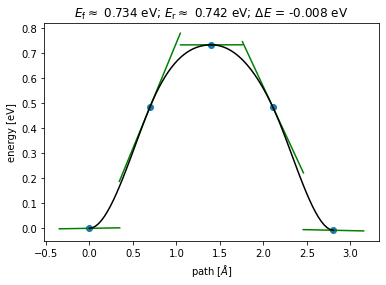

In [9]:
def neb_analysis(images, label, ax=None):
  nebtools = NEBTools(images)
  barrier, dE = nebtools.get_barrier()
  #max_force = nebtools.get_fmax()
  fig = nebtools.plot_band(ax=ax)
  fig.savefig(label+'.png', dpi=300)
  return barrier, dE

images = read(f'neb_example_iter_{training_params["al_convergence"]["num_iterations"]}.traj@-{total_neb_images}:')

# to verify ml_computed images...evaluate with parent calculator
'''emt_evaluated_images = []
for image in images:
  #image = image.copy()
  image.set_calculator(parent_calc)
  emt_evaluated_images.append(image)'''

barrier_ml, dE_ml = neb_analysis(images, label="ml_diffusion_neb")

In [10]:
'''barrier_emt_ml, dE_emt_ml, max_force_emt_ml = neb_analysis(emt_evaluated_images, label="emt@ml_diffusion_neb")
print(f"ML barrier pred = {barrier_ml}, ml dE pred = {dE_ml}, ml max force = {max_force_ml}")
print(f"emt@ml barrier = {barrier_emt_ml}, emt@ml dE = {dE_emt_ml}, emt@ml max force = {max_force_emt_ml}")'''
print(f"AL: Total number of force calls = {initial_force_calls} (initial data) + {learner.parent_calls} (AL-NEB) = {initial_force_calls+learner.parent_calls}")

AL: Total number of force calls = 80 (initial data) + 25 (AL-NEB) = 105


#### Code to generate true NEB

In [11]:
emt_counter = CounterCalc(Espresso(pw=500.0, 
                calculation='scf',
                kpts=(4,4,1),
                xc='PBE'))
if not ml2relax:
  # Load previously computed relaxed states
  initial_slab1 = read("initial.traj", "-1")
  final_slab1 = read("final.traj", "-1")
else:
  initial.set_calculator(emt_counter)
  final.set_calculator(emt_counter)
  qn = QuasiNewton(initial, trajectory='parent_initial.traj', logfile='initial_relax_log.txt')
  qn.run(fmax=0.05, steps=200)
  qn = QuasiNewton(final, trajectory='parent_final.traj', logfile='final_relax_log.txt')
  qn.run(fmax=0.05, steps=200)
  initial_slab1 = read("parent_initial.traj", "-1")
  final_slab1 = read("parent_final.traj", "-1")

images = [initial_slab1]
for i in range(3):
    image = final_slab1.copy()
    image.set_calculator(emt_counter)
    images.append(image)
images.append(final_slab1)

neb = SingleCalculatorNEB(images)
neb.interpolate()
qn = BFGS(neb, trajectory='actual_neb.traj')
qn.run(fmax=0.05)

      Step     Time          Energy         fmax
BFGS:    0 18:34:02   -66355.669339       11.7491
BFGS:    1 18:36:43   -66356.701801        8.2380
BFGS:    2 18:39:17   -66357.283044        5.9267
BFGS:    3 18:42:02   -66357.630820        4.2495
BFGS:    4 18:44:44   -66357.839857        2.9809
BFGS:    5 18:47:28   -66357.963466        1.9872
BFGS:    6 18:50:06   -66358.032949        1.1984
BFGS:    7 18:52:47   -66358.069531        0.5654
BFGS:    8 18:55:24   -66358.087767        0.6921
BFGS:    9 18:58:03   -66358.099032        0.8248
BFGS:   10 19:00:32   -66358.111427        0.8033
BFGS:   11 19:03:13   -66358.130970        0.5705
BFGS:   12 19:05:50   -66358.146570        0.2533
BFGS:   13 19:08:31   -66358.151127        0.1566
BFGS:   14 19:11:11   -66358.152291        0.1783
BFGS:   15 19:13:48   -66358.153503        0.2494
BFGS:   16 19:16:24   -66358.155305        0.2156
BFGS:   17 19:19:02   -66358.156709        0.0848
BFGS:   18 19:21:39   -66358.156799        0.0373


True

Ef = 0.7296563091076679, dE = -0.0003790546179516241
Total number of force calls = 80 (initial data) + 57 Total = 137


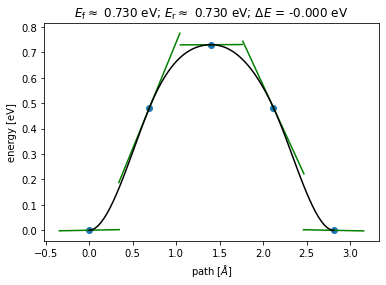

In [12]:
images = read(f'actual_neb.traj@-{total_neb_images}:')
nebtools = NEBTools(images)

Ef, dE = neb_analysis(images, label="actual_emt_neb")

print(f"Ef = {Ef}, dE = {dE}")
print(f"Total number of force calls = {initial_force_calls} (initial data) + {emt_counter.force_calls} Total = {initial_force_calls+emt_counter.force_calls}")